# ARID1A proteomics cis comparison

## Step 1: Library Imports

Run this cell to import the necessary libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats

import cptac
import cptac.algorithms as al

In [4]:
def format_cis_comparison_data(cancer_object, specific_omics, gene):
    
    # Step 1 - Create dataframe in order to do comparisons with wrap_ttest - drop nan values
    omics_and_mutations = cancer_object.append_mutations_to_omics(
        mutation_genes = gene, omics_df_name = specific_omics.name, omics_genes = gene).dropna()

    # Check if values in omics data (if not found in proteomics, after na dropped dataframe should be empty)
    if omics_and_mutations[gene+"_"+specific_omics.name].empty:
        print('Not possible to do T-test. No data for', gene, 'in', specific_omics.name)
        return None
    else:
        
        # Step 2 - Create the binary column needed to do the comparison
        omics_and_mutations['binary_mutations'] = np.where(
            omics_and_mutations[gene+'_Mutation_Status'] == 'Wildtype_Tumor', 'Wildtype', 'Mutated')

        # Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
        tumors = omics_and_mutations.loc[omics_and_mutations['Sample_Status'] == 'Tumor']
        columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
        omics_binary_mutations = tumors.drop(columns_to_drop, axis = 1)
        #check if only one column of omics data (total 2 columns)
        if len(omics_binary_mutations.columns) != 2:
            print('exeption with columns. check omics data')
            return None
        else:
            # Make a list of the column label of omics to be used in the wrap_ttest function
            omics_col_list = [omics_binary_mutations.columns[0]] 

            # Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
            print("Doing t-test comparison\n")
            significant_pval_results = al.wrap_ttest(omics_binary_mutations, 'binary_mutations', omics_col_list)
            print(significant_pval_results)
            
            

            formated_data_for_boxplot = {'data': omics_binary_mutations, 'data_compare_mutation_type':  'x': "binary_mutations", 
                                         'y': gene+"_proteomics", 'pval': significant_pval_results}
            return formated_data_for_boxplot

  

In [78]:
def get_missence_truncation_comparison(cancer_object, specific_omics, gene):
    
    
    somatic_mutations = cancer_object.get_mutations().reset_index()
    gene_df = somatic_mutations.loc[somatic_mutations['Gene'] == gene]
    #tumors = somatic_mutations.loc[somatic_mutations['Sample_Status'] == 'Tumor']
    
    
    #data for mutation comparison
    if cancer_object.get_cancer_type() == 'colon':
        missence_truncation_groups = {'frameshift substitution': 'T', 
            'frameshift deletion': 'T', 'frameshift insertion': 'T', 
            'stopgain': 'T', 'stoploss': 'T', 'nonsynonymous SNV': 'M',
            'nonframeshift insertion': 'M','nonframeshift deletion': 'M', 
            'nonframeshift substitution': 'M'}
    else: 
        missence_truncation_groups = {'In_Frame_Del': 'M', 'In_Frame_Ins': 'M',
            'Missense_Mutation': 'M', 'Frame_Shift_Del': 'T','Nonsense_Mutation': 'T', 
            'Splice_Site': 'T', 'Frame_Shift_Ins': 'T','Nonstop_Mutation':'T'}
        
    mutations_replaced_M_T = gene_df.replace(missence_truncation_groups)
    
    # group mutation categories
    miss = mutations_replaced_M_T.loc[mutations_replaced_M_T['Mutation'] == 'M']
    trunc = mutations_replaced_M_T.loc[mutations_replaced_M_T['Mutation'] == 'T']
    
    #get lists of unique samples for missence and trucation categories
    miss_unique_samples = miss['Sample_ID'].unique()
    
    #
    omics_and_mutations = cancer_object.append_mutations_to_omics(
            mutation_genes = gene, omics_df_name = specific_omics.name, omics_genes = gene).reset_index()
    #m = omics_and_mutations.loc[omics_and_mutations['Sample_ID'] is miss_unique_samples]
    
    #print(mutations_replaced_M_T)
    return miss_unique_samples
#df[df.index.isin([1,3])]

## Step 2: Find the frequently mutated genes for Endometrial Cancer

Enter the type of cancer and the cutoff for mutation frequency that you would like to use.

In [32]:
en_object = cptac.Endometrial()
desired_cutoff = .1

endometrial_freq_mut = al.get_frequently_mutated(en_object, cutoff=desired_cutoff)
print('\n\nNumber of Frequently Mutated Genes:', len(endometrial_freq_mut), '\n', endometrial_freq_mut.head())

matting dataframes...linear data.....

Number of Frequently Mutated Genes: 232 
      Gene  Unique_Samples_Mut  Missence_Mut  Truncation_Mut
0  ABCA12            0.147368      0.094737        0.073684
1  ABCA13            0.115789      0.105263        0.042105
2  ACVR2A            0.105263      0.010526        0.094737
3  ADGRG4            0.136842      0.126316        0.021053
4  ADGRV1            0.115789      0.094737        0.052632


## Step 3: Select a gene from the list of frequently mutated genes above

Set the gene to which of the above frequently mutated genes you want to examine. For example, if you want to look at the gene PTEN, change the cell below to say "gene = 'KRAS'"

In [33]:
gene = 'ARID1A'

## Step 4: Select desired omics comparison

Select which type of omics you want to compare. If you want to compare proteomics data for the interacting proteins, uncomment the "omics = en.get_proteomics()" line, etc.

In [74]:
omics = en_object.get_proteomics()
#omics = en_object.get_transcriptomics()
#omics = en_object.get_phosphoproteomics()
#omics = en_object.get_acetylproteomics()

In [79]:
mutation_type_comparison = get_missence_truncation_comparison(en_object, omics, gene)
mutation_type_comparison

array(['S001', 'S014', 'S022', 'S024', 'S027', 'S037', 'S059', 'S064',
       'S073', 'S079', 'S085', 'S094', 'S099'], dtype=object)

## Step 5: cis comparison 

Determine if the DNA mutation has an effect on the omics measurement. In order to do this, we have a few steps in code. These steps are found in the format_cis_comparison_data function.
1. get a table with both the omics and mutation data for tumors
2. get a binary column from the mutation data to separate our samples
3. format data frame to be used in the T-test
4. send data to the T-test.

The format_cis_comparison_data function returns a dictionary with the data, x, and y names needed to plot the comparison and the p-value.

In [35]:
data_for_comparison = format_cis_comparison_data(en_object, omics, gene)

Doing t-test comparison

          Comparison       P_Value
0  ARID1A_proteomics  1.025018e-10


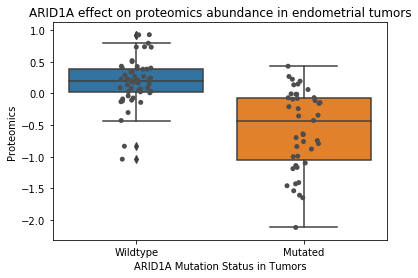

In [9]:
# Step 5 - Create boxplt to compare wildtype and mutated effect on omics data
en_cis_boxplot = sns.boxplot(data = data_for_comparison['data'], x = data_for_comparison['x'],
                          y =data_for_comparison['y'], order = ["Wildtype","Mutated"])  
en_cis_boxplot.set_title(gene + " effect on " + omics.name + " abundance in endometrial tumors")
en_cis_boxplot = sns.stripplot(data= data_for_comparison['data'], x = data_for_comparison['x'],
                            y = data_for_comparison['y'],jitter = True, color = ".3", order = ["Wildtype","Mutated"])
en_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()

In [52]:
mutation_type_comparison = get_missence_truncation_comparison(en_object, omics, gene)
mutation_type_comparison.head()

,Gene,Mutation,Location
Sample_ID,,,
S001,MXRA8,T,p.R301Gfs*107
S001,GNB1,M,p.R314C
S001,RPL22,M,p.V72M
S001,CASZ1,M,p.R233Q
S001,PRAMEF9,M,p.L30M


# Repeat with the Colon dataset

Go through the same process, this time using the Colon dataset. We will only print five genes from the frequently mutated data frame for simplicity.

In [10]:
colon_object = cptac.Colon()
desired_cutoff = .1

colon_freq_mut = al.get_frequently_mutated(colon_object, cutoff=desired_cutoff)
print('\n\nNumber of Frequently Mutated Genes:', len(colon_freq_mut), '\n', colon_freq_mut.head())

matting dataframes...data.....ata....

Number of Frequently Mutated Genes: 612 
      Gene  Unique_Samples_Mut  Missence_Mut  Truncation_Mut
0  ABCA13            0.195876      0.164948        0.103093
1   ABCA2            0.175258      0.164948        0.030928
2   ABCA4            0.144330      0.082474        0.061856
3   ABCB4            0.134021      0.061856        0.072165
4   ABCB6            0.103093      0.061856        0.041237


In [16]:
gene = 'ARID1A'

co_omics = colon_object.get_proteomics()
#co_omics = colon_object.get_transcriptomics()
#co_omics = colon_object.get_phosphoproteomics()
#co_omics = colon_object.get_acetylproteomics()

In [17]:
co_data_for_comparison = format_cis_comparison_data(colon_object, co_omics, gene)


Doing t-test comparison

          Comparison   P_Value
0  ARID1A_proteomics  0.001305


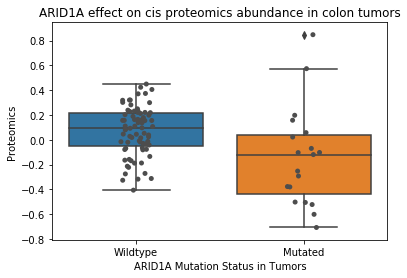

In [18]:
cis_boxplot = sns.boxplot(data = co_data_for_comparison['data'], x = co_data_for_comparison['x'],
                          y = co_data_for_comparison['y'], order = ["Wildtype","Mutated"])  
cis_boxplot.set_title(gene + " effect on cis " + omics.name + " abundance in colon tumors")
cis_boxplot = sns.stripplot(data = co_data_for_comparison['data'], x = co_data_for_comparison['x'],
                            y = co_data_for_comparison['y'], jitter = True, color = ".3", 
                            order = ["Wildtype","Mutated"])
cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()

# Repeat with the Ovarian dataset


In [19]:
ovarian_object = cptac.Ovarian()
desired_cutoff = .1

ovarian_freq_mut = al.get_frequently_mutated(ovarian_object, cutoff=desired_cutoff)

In [20]:
gene = 'ARID1A'

ov_omics = ovarian_object.get_proteomics()
#ov_omics = ovarian_object.get_transcriptomics()
#ov_omics = ovarian_object.get_phosphoproteomics()
#ov_omics = ovarian_object.get_acetylproteomics()

In [21]:
ov_data_for_comparison = format_cis_comparison_data(ovarian_object, ov_omics, gene)

Doing t-test comparison

No significant comparisons.
None


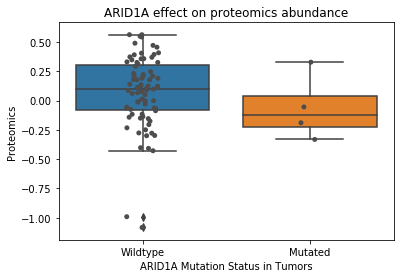

In [22]:
# Step 5 - Visualize comparison
ov_cis_boxplot = sns.boxplot(data = ov_data_for_comparison['data'], x = ov_data_for_comparison['x'],
                          y = ov_data_for_comparison['y'], order = ["Wildtype","Mutated"])  
ov_cis_boxplot.set_title(gene + " effect on " + omics.name + " abundance")
ov_cis_boxplot = sns.stripplot(
    data = ov_data_for_comparison['data'], x = ov_data_for_comparison['x'],y = ov_data_for_comparison['y'], 
    jitter = True, color = ".3", order = ["Wildtype","Mutated"])
ov_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()